In [342]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from functools import reduce

In [640]:
def unary(x, C):
    nearest_x = int(np.round(x))
    return(np.r_[np.ones(nearest_x), np.zeros(C-nearest_x)])

def lsh_hash(point, C):
    # see if I can just vectorize the unary function?
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

def get_cluster_points(idx, clusters, data): # memoize / cache this?
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(clusters == point_cluster)[0]
    same_cluster_points = set(map(tuple, data[same_cluster_points_idx, :]))

    return same_cluster_points

In [659]:
# set l, k, A, Pmiss?
# figure out how to make dendrogram

iris_full = datasets.load_iris().data
iris = iris_full[:, :2]
#iris_head = iris[:10,].copy()

A = 1.4
l = 10
k = 100
#l = 3
# k = 5
C = 50
#C = int(np.ceil(np.max(iris))) + 1 # maximal coordinate value of any point is less than C
n, d = iris.shape
clusters = np.arange(n)
num_clusters = len(np.unique(clusters))

# randomly sample sqrt(n) points from data to set initial value for r? or use formula below?
np.random.seed(5)
n_samp = int(np.ceil(np.sqrt(n)))
samples = iris[np.random.choice(n, size = n_samp, replace = False), :]

# r = min distance between any 2 points in sample
#r = np.min(pdist(samples, 'euclidean'))

r = (d * C * np.sqrt(d)) / (2 * (k + d))

In [660]:
C

50

In [661]:
r

0.6932419423397524

In [662]:
# Step 1: Generation of hash tables

def build_hash_tables(C, d, l, k, data):
    vals = np.arange(C*d)
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l): # use multiprocessing to speed this up? separate thread for each hash function?
        #print(len(vals), k)
        I = np.random.choice(vals, k, replace = False) # need sampling with replacement if k > n

        for j in range(n):
            point = data[j]
            hashed_point = lsh_hash(point, C)[I]
            bucket = hash_tables[tuple(hashed_point)]
            same_cluster_points = get_cluster_points(j, clusters, data)

            # only add point to hash table if no other points from its cluster are in the bucket
            if not same_cluster_points.intersection(bucket):
                hash_tables[tuple(hashed_point)].add(tuple(point))
                hash_tables_reversed[tuple(point)].add(tuple(hashed_point))
    
    return hash_tables, hash_tables_reversed

In [663]:
Z = np.zeros((n-1, 4))
Z.shape

(149, 4)

In [664]:
count = 0
np.random.seed(6)

while num_clusters > 1 and count < 20:
    # Step 1: Generation of hash tables
    hash_tables, hash_tables_reversed = build_hash_tables(C, d, l, k, iris)
    
    # Step 2: Nearest neighbor search for q
    
    for i in range(n):
        q = iris[i]
        q_buckets = hash_tables_reversed[tuple(q)]
        
#         print("hash_tables")
#         print(hash_tables)
#         print("\n")
#         print("hash_tables_reversed")
#         print(hash_tables_reversed)
#         print("\n")

        # get points that share a bucket with q
#        print(i)
#         if i == 2:
#             print(tuple(q))
#             print(hash_tables_reversed[tuple(q)])
        
        if hash_tables_reversed[tuple(q)]: # check if point is in any hash tables
            sim_points = reduce(
                lambda x, y: x.union(y),
                map(lambda x: hash_tables[x], q_buckets)
                ).difference(get_cluster_points(i, clusters, iris)) # difference should be on all points in q's cluster
            sim_points = np.array(list(sim_points))

            # Step 3: Connect pairs of clusters within certain distance of q

            # find indices of similar points p s.t. dist(q, p) < r and merge clusters
            # need to convert the clusters for all points that are in the same clusters as the p's
            if sim_points.size:
                points_to_join = sim_points[np.where(np.linalg.norm(q - sim_points, axis = 1) < r)[0]]

                # find the clusters that should be combined with point q's cluster
                clusters_to_join = clusters[np.where((iris == points_to_join[:,None]).all(-1))[1]]
                print(clusters_to_join)

                clusters[np.where(np.in1d(clusters, clusters_to_join))[0]] = clusters[i]

    # Step 4: update parameters and continue until num_clusters == 1

    num_clusters = len(np.unique(clusters))
    count += 1

    #increase r and decrease k
    r *= A
    k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))
    
#     print(num_clusters, r, k)
#     print(clusters)
#     print('\n')

[32 10  5 16  4 21 27 40 43 48 19 44 46 22]
[25 28 49 39 84 35 20 31 23  7 26 30 47  3  6  2 29 59  9 34 37 11 24 12
 45]
[13 42 38]
[33 15 36 18]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[102 125 129  58  76 130 107  52 139 141  75  65  86 140  77 145 112 120
 124 144 143]
[ 54  63  71  73  74  78  83  97 103 111 123 133  70  61 149 138 134  91
 127  56 100  85 104 116 147 110 136 137 126 148 128 132]
[ 89 113  62 119  80  81  69]
[]
[ 51  51  51  51  51  51  51  51  90  51 114  66  88  51  95  51  51  92
  51  94  51  96  51  51  51  51  67  82 101 142  64  79 121]
[106  93  98  60]
[ 72 146  68  87]
[55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55
 55 55 55 55 55 55 55 55 55]
[135 122 118]
[99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99 99 99 99 99 99]
[131]
[14  1]
[57 53]
[41]
[]
[109 117 105 115 115 108]
[]
[]
[]
[]
[]
[]
[]
[]
[8]
[]
[]
[50 50]


In [607]:
clusters = np.array([17, 1, 1, 1, 17, 17, 1, 1, 8, 1, 17, 1, 1, 8, 14, 14, 17, 17, 14, 17, 1, 17, 17, 1, 1, 1, 1, 17, 1, 1, 1, 1, 17, 14, 1, 1, 14, 1, 8, 1, 17, 41, 8, 17, 17, 1, 17, 1, 17, 1, 50, 115, 50, 53, 115, 115, 115, 57, 50, 1, 57, 115, 53, 115, 115, 50, 115, 115, 53, 53, 115, 115, 53, 115, 115, 50, 50, 50, 115, 115, 53, 53, 115, 115, 1, 115, 50, 53, 115, 53, 115, 115, 115, 57, 115, 115, 115, 115, 57, 115, 115, 115, 50, 115, 115, 105, 57, 50, 108, 109, 115, 115, 50, 53, 115, 115, 115, 117, 105, 53, 50, 115, 105, 115, 50, 50, 115, 115, 115, 50, 50, 117, 115, 115, 115, 105, 115, 115, 115, 50, 50, 50, 115, 50, 50, 50, 53, 115, 115, 115])

In [608]:
clusters.shape

(150,)

In [609]:
iris.shape

(150, 2)

In [611]:
g1 = np.where(clusters == np.unique(clusters)[0])[0]
g2 = np.where(clusters == np.unique(clusters)[1])[0]
g3 = np.where(clusters == np.unique(clusters)[2])[0]
g4 = np.where(clusters == np.unique(clusters)[3])[0]
g5 = np.where(clusters == np.unique(clusters)[4])[0]
g6 = np.where(clusters == np.unique(clusters)[5])[0]
g7 = np.where(clusters == np.unique(clusters)[6])[0]
g8 = np.where(clusters == np.unique(clusters)[7])[0]
g9 = np.where(clusters == np.unique(clusters)[8])[0]
g10 = np.where(clusters == np.unique(clusters)[9])[0]
g11 = np.where(clusters == np.unique(clusters)[10])[0]
g12 = np.where(clusters == np.unique(clusters)[11])[0]
g13 = np.where(clusters == np.unique(clusters)[12])[0]

In [ ]:
plt.scatter(data[g1,0], data[g1,1], marker='o', facecolors = 'none', edgecolors = 'b', s = 15)
plt.scatter(data[g2,0], data[g2,1], marker='o', facecolors = 'none', edgecolors = 'g', s = 15)
plt.xlabel('x', size = 13)
plt.ylabel('y', size = 13)
plt.axis('square');

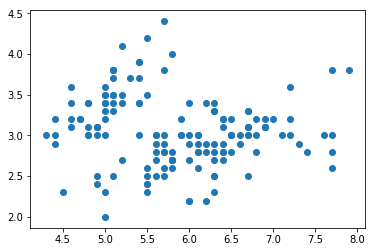

In [613]:
plt.scatter(iris[:,0], iris[:,1]);

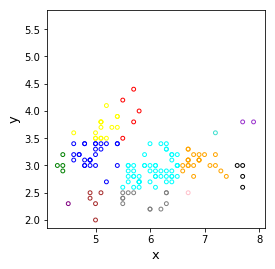

In [618]:
plt.scatter(iris[g1,0], iris[g1,1], marker='o', facecolors = 'none', edgecolors = 'blue', s = 15)
plt.scatter(iris[g2,0], iris[g2,1], marker='o', facecolors = 'none', edgecolors = 'green', s = 15)
plt.scatter(iris[g3,0], iris[g3,1], marker='o', facecolors = 'none', edgecolors = 'red', s = 15)
plt.scatter(iris[g4,0], iris[g4,1], marker='o', facecolors = 'none', edgecolors = 'yellow', s = 15)
plt.scatter(iris[g5,0], iris[g5,1], marker='o', facecolors = 'none', edgecolors = 'purple', s = 15)
plt.scatter(iris[g6,0], iris[g6,1], marker='o', facecolors = 'none', edgecolors = 'orange', s = 15)
plt.scatter(iris[g7,0], iris[g7,1], marker='o', facecolors = 'none', edgecolors = 'gray', s = 15)
plt.scatter(iris[g8,0], iris[g8,1], marker='o', facecolors = 'none', edgecolors = 'brown', s = 15)
plt.scatter(iris[g9,0], iris[g9,1], marker='o', facecolors = 'none', edgecolors = 'black', s = 15)
plt.scatter(iris[g10,0], iris[g10,1], marker='o', facecolors = 'none', edgecolors = 'pink', s = 15)
plt.scatter(iris[g11,0], iris[g11,1], marker='o', facecolors = 'none', edgecolors = 'turquoise', s = 15)
plt.scatter(iris[g12,0], iris[g12,1], marker='o', facecolors = 'none', edgecolors = 'cyan', s = 15)
plt.scatter(iris[g13,0], iris[g13,1], marker='o', facecolors = 'none', edgecolors = 'darkorchid', s = 15)
plt.xlabel('x', size = 13)
plt.ylabel('y', size = 13)
plt.axis('square');

In [619]:
clusters2 = np.array([17, 17, 17, 17, 17, 17, 17, 17, 8, 17, 17, 17, 17, 8, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 8, 17, 17, 8, 8, 17, 17, 17, 17, 17, 17, 17, 50, 50, 50, 17, 50, 50, 50, 17, 50, 17, 17, 50, 17, 50, 50, 50, 50, 50, 17, 17, 50, 50, 17, 50, 50, 50, 50, 50, 50, 50, 17, 17, 50, 50, 17, 50, 50, 17, 50, 17, 50, 50, 50, 17, 50, 50, 50, 50, 17, 50, 50, 50, 50, 50, 50, 50, 17, 50, 50, 50, 50, 50, 50, 17, 50, 50, 50, 50, 50, 17, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 17, 50, 50, 50])

In [620]:
clusters2.shape

(150,)

In [621]:
q1 = np.where(clusters2 == np.unique(clusters2)[0])[0]
q2 = np.where(clusters2 == np.unique(clusters2)[1])[0]
q3 = np.where(clusters2 == np.unique(clusters2)[2])[0]

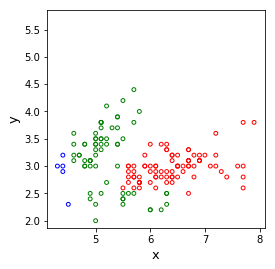

In [622]:
plt.scatter(iris[q1,0], iris[q1,1], marker='o', facecolors = 'none', edgecolors = 'blue', s = 15)
plt.scatter(iris[q2,0], iris[q2,1], marker='o', facecolors = 'none', edgecolors = 'green', s = 15)
plt.scatter(iris[q3,0], iris[q3,1], marker='o', facecolors = 'none', edgecolors = 'red', s = 15)
plt.xlabel('x', size = 13)
plt.ylabel('y', size = 13)
plt.axis('square');

In [646]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [639]:
from scipy.cluster.hierarchy import linkage, dendrogram

a = np.array([[0.1,   2.5],
              [1.5,   .4 ],
              [0.3,   1  ],
              [1  ,   .8 ],
              [0.5,   0  ],
              [0  ,   0.5],
              [0.5,   0.5],
              [2.7,   2  ],
              [2.2,   3.1],
              [3  ,   2  ],
              [3.2,   1.3]])

z = linkage(a, method="single")
z

dendrogram(z)
plt.show()

array([[ 7.        ,  9.        ,  0.3       ,  2.        ],
       [ 4.        ,  6.        ,  0.5       ,  2.        ],
       [ 5.        , 12.        ,  0.5       ,  3.        ],
       [ 2.        , 13.        ,  0.53851648,  4.        ],
       [ 3.        , 14.        ,  0.58309519,  5.        ],
       [ 1.        , 15.        ,  0.64031242,  6.        ],
       [10.        , 11.        ,  0.72801099,  3.        ],
       [ 8.        , 17.        ,  1.2083046 ,  4.        ],
       [ 0.        , 16.        ,  1.5132746 ,  7.        ],
       [18.        , 19.        ,  1.92353841, 11.        ]])

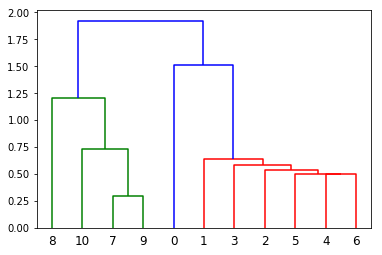

In [648]:
dendrogram(z)
plt.show()

In [459]:
### Question 3b - Hierarchical Agglomerative Clustering
# single-linkage clustering: https://en.wikipedia.org/wiki/Single-linkage_clustering

def hac(k, data):
    n = data.shape[0]
    
    # start with each point in its own cluster
    clusters = np.arange(n)
    num_clusters = len(np.unique(clusters))
    
    while num_clusters > k:
        min_distances = np.zeros(n)
        min_points = np.zeros(n).astype('int')

        # for each point, find min distance to point not in cluster
        for i in range(n):
            point = data[i,]
            point_cluster = clusters[i]
            distances = np.linalg.norm(point - data, axis = 1)
            diff_cluster_points = np.where(clusters != point_cluster)[0]

            min_points[i] = diff_cluster_points[np.argmin(distances[diff_cluster_points])]
            min_distances[i] = distances[min_points[i]]

        # merge clusters of the two closest points
        point1_idx = np.argmin(min_distances)
        point1 = data[point1_idx,]
        point2_idx = min_points[point1_idx]
        point2 = data[point2_idx,]

        point2_cluster = clusters[point2_idx]
        clusters[np.where(clusters == point2_cluster)[0]] = clusters[point1_idx]

        # update number of clusters
        num_clusters = len(np.unique(clusters))
    
    return clusters

In [460]:
k = 1
clusters_hac = hac(k, iris)